# Radial velocity fitting, TOI 1273

In [1]:
import exoplanet as xo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"]=8,6
plt.rcParams.update({'font.size': 16})

In [2]:
data = pd.read_table('1273_preliminary_rv_sophie.dat', sep='\s+')
data.rename(columns={'rv(km/s)': 'rv', 'sigRV(km/s)':'err'}, inplace=True)

In [3]:
x = np.array(data.bjd-2457000)
y = np.array((data.rv-data.rv.mean())*1000)
yerr = np.array(data.err*1000)

46


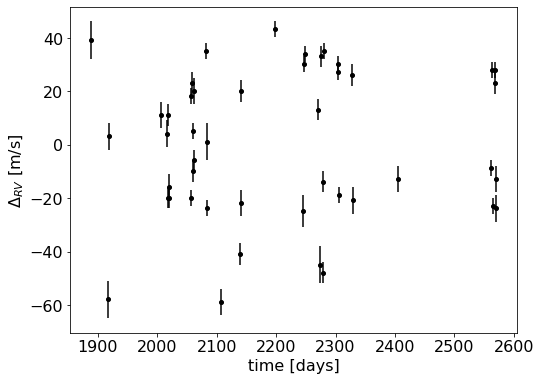

In [4]:
plt.errorbar(x, y, yerr=yerr, fmt=".k", markersize=8)
plt.xlabel("time [days]")
print(len(x))
_ = plt.ylabel("$\Delta_{RV}$ [m/s]")

In [5]:
# Compute a reference time that will be used to normalize the trends model
x_ref = 0.5 * (x.min() + x.max())

# Also make a fine grid that spans the observation window for plotting purposes
t = np.linspace(x.min() - 5, x.max() + 5, 3000)

# We know the period and transit times from the TESS data BLS parameters 
# we also know the duration and depth. let's estimate the expected semi-amplitude K for the planet

period = 4.63123
period_err = 0.00004
t0 = 2458712.34791-2457000.0
t0_err = 0.0009

#Stellar parameters from Sousa using SOPHIE spectra, hay 4 valores distintos de logg, aca agarré el primero
m_star = 1.07
m_star_err = 0.03
logg_star = 4.335

from astropy import constants as const
from astropy import units as u
# calculate stellar radius from mass and surface gravity
g_star = (10**(logg_star) * u.cm / u.s**2).si
r_star = (np.sqrt(const.G.value*const.M_sun.value/g_star.value)*u.m).to(u.R_sun).value
print(r_star)

K = xo.estimate_semi_amplitude(period, x, y, yerr, t0s=t0)
print(K, "m/s")

1.1259881335783577
[31.38105766] m/s


## Radial velocity model in PyMC3

In [6]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt

In [7]:
with pm.Model() as model:
    # Gaussian priors based on transit data
    t0 = pm.Normal("t0", mu=t0, sd=t0_err) # we can't use it if we want to use t_periastron
    logP = pm.Normal("logP", mu=np.log(period), sd=period_err/period)
    P = pm.Deterministic("P", tt.exp(logP))
    
    # Wide log-normal prior for semi-amplitude
    logK = pm.Normal("logK", mu=np.log(K.item()), sd=2.0)

    # Eccentricity & argument of periasteron
    # sqrt(e)*sin(omega) and sqrt(e)*cos(omega) as your parameters:
    ecs = pmx.UnitDisk("ecs", testval=0.01 * np.ones(2), shape=2)
    ecc = pm.Deterministic("ecc", tt.sum(ecs**2, axis=0))
    omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
    # The beta eccentricity distribution fit by Kipping (2013)
    #xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

    # # At low eccentricity, omega and the phase of periastron (phi) are
    # # correlated so it can be best to fit in (omega ± phi) / 2
    # ecc = pm.Uniform("ecc", lower=0, upper=1)
    # plus = pmx.Angle("plus")
    # minus = pmx.Angle("minus")

    # phi = pm.Deterministic("phi", plus + minus)
    # omega = pm.Deterministic("omega", plus - minus)

    
    # Jitter & a quadratic RV trend
    logs = pm.Normal("logs", mu=np.log(np.median(yerr)), sd=5.0)
    trend = pm.Normal("trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3)  # [2,1,0]
    
    # # Time of periastron passage
    # tperi = pm.Deterministic("tperi", P * phi / (2 * np.pi))
    
    # Then we define the orbit
    # at most two of m_star, r_star, and rho_star can be defined.
    # stellar parameters from fop, los que envió guillaume no tienen el radio, lo reemplazo por rho_star
    orbit = xo.orbits.KeplerianOrbit(period=P, t0=t0, ecc=ecc, omega=omega, m_star=m_star, r_star=r_star) # t0 or t_periastron

    # And a function for computing the full RV model
    def get_rv_model(t, name=""):
        # First the RVs induced by the planet
        vrad = orbit.get_radial_velocity(t, K=tt.exp(logK))
        pm.Deterministic("vrad" + name, vrad)

        # Define the background model
        A = np.vander(t - x_ref, 3) # Generate a Vandermonde matrix with t-x_ref as input vector
        bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

        # Sum over planets and add the background to get the full model
        return pm.Deterministic("rv_model" + name, vrad + bkg)

    # Define the RVs at the observed times
    rv_model = get_rv_model(x)

    # Also define the model on a fine grid as computed above (for plotting)
    rv_model_pred = get_rv_model(t, name="_pred")

    # Finally add in the observation model. This next line adds a new contribution
    # to the log probability of the PyMC3 model
    err = tt.sqrt(yerr**2 + tt.exp(2 * logs))
    pm.Normal("obs", mu=rv_model, sd=err, observed=y)

In [8]:
model.basic_RVs

[logP ~ Normal,
 logK ~ Normal,
 ecc_interval__ ~ TransformedDistribution,
 plus_angle__ ~ TransformedDistribution,
 minus_angle__ ~ TransformedDistribution,
 logs ~ Normal,
 trend ~ Normal,
 obs ~ Normal]

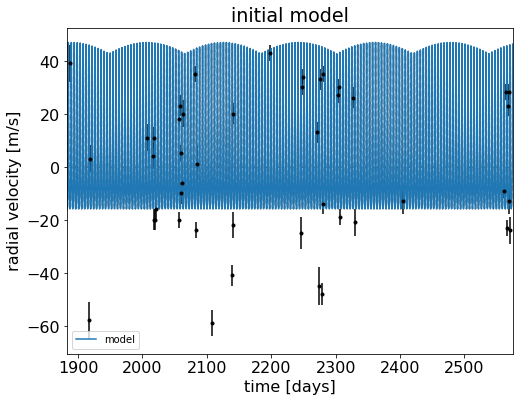

In [9]:
# Now, we can plot the initial model.
plt.errorbar(x, y, yerr=yerr, fmt=".k")

with model:
    plt.plot(t, pmx.eval_in_model(model.vrad_pred), "--k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.bkg_pred), ":k", alpha=0.5)
    plt.plot(t, pmx.eval_in_model(model.rv_model_pred), label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
#plt.xlim(2000,2100)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("initial model")

The background is the dotted line, the individual planets are the dashed lines, and the full model is the blue line.

Now let's fit for the maximum a posterior parameters.

In [10]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[trend])
    map_soln = pmx.optimize(start=map_soln, vars=[t0, trend, logK, logP, logs]) #t0 or plus and minus
    map_soln = pmx.optimize(start=map_soln, vars=[ecs]) # ecs or ecc
    map_soln = pmx.optimize(start=map_soln)

optimizing logp for variables: [trend]


message: Optimization terminated successfully.
logp: -1590.4569878611196 -> -1583.6058893906788
optimizing logp for variables: [logs, logP, logK, trend, minus, plus]


message: Desired error not necessarily achieved due to precision loss.
logp: -1583.6058893906788 -> -138.39783707414847
optimizing logp for variables: [ecc]


message: Optimization terminated successfully.
logp: -138.39783707414847 -> -135.41719628085232
optimizing logp for variables: [trend, logs, minus, plus, ecc, logK, logP]


message: Desired error not necessarily achieved due to precision loss.
logp: -135.41719628085232 -> -131.48535538223993


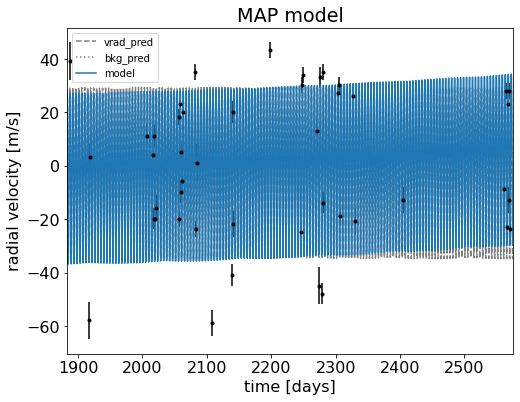

In [11]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")
plt.plot(t, map_soln["vrad_pred"], "--k", alpha=0.5, label='vrad_pred')
plt.plot(t, map_soln["bkg_pred"], ":k", alpha=0.5, label='bkg_pred')
plt.plot(t, map_soln["rv_model_pred"], label="model")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
#plt.xlim(2000,2100)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("MAP model")

## Sampling

Now that we have our model set up and a good estimate of the initial parameters, let's start sampling.
There are substantial covariances between some of the parameters so we'll use the `pmx.sample` function from [pymc3-ext](https://github.com/exoplanet-dev/pymc3-ext) which wraps `pm.sample` function with some better defaults and tuning strategies.

In [12]:
model.free_RVs

[logP ~ Normal,
 logK ~ Normal,
 ecc_interval__ ~ TransformedDistribution,
 plus_angle__ ~ TransformedDistribution,
 minus_angle__ ~ TransformedDistribution,
 logs ~ Normal,
 trend ~ Normal]

In [13]:
np.random.seed(42)
with model:
    trace = pmx.sample(
        tune=3000, #1000
        draws=2000, #1000
        cores=2, 
        chains=4, #2
        target_accept=0.9,
        return_inferencedata=True,
    )

Multiprocess sampling (4 chains in 2 jobs)
NUTS: [trend, logs, minus, plus, ecc, logK, logP]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 91 seconds.


After sampling, it's always a good idea to do some convergence checks.
First, let's check the number of effective samples and the Gelman-Rubin statistic for our parameters of interest:

In [14]:
import arviz as az

#az.summary(trace)
az.summary(trace, var_names=['trend', 'logs', 'ecs', 'ecc', 't0', 'logK', 'P', 'omega'])
#az.summary(trace, var_names=['trend', 'logs', 'minus', 'plus', 'phi', 'omega', 'ecc', 'tperi', 'logK', 'P'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
trend[0],0.000,0.000,-0.000,0.000,0.000,0.000,7837.0,5713.0,1.0
trend[1],0.010,0.010,-0.009,0.029,0.000,0.000,8470.0,5719.0,1.0
trend[2],0.257,0.946,-1.562,1.976,0.009,0.010,10795.0,6115.0,1.0
logs,2.466,0.133,2.222,2.720,0.001,0.001,8207.0,5690.0,1.0
minus,-1.632,0.049,-1.725,-1.539,0.001,0.000,8976.0,5519.0,1.0
plus,0.185,1.523,-2.419,3.111,0.027,0.021,3450.0,4766.0,1.0
phi,-1.447,1.528,-4.135,1.406,0.027,0.019,3447.0,4943.0,1.0
omega,1.817,1.520,-0.831,4.687,0.027,0.020,3450.0,4732.0,1.0
ecc,0.078,0.060,0.000,0.187,0.001,0.000,4877.0,2626.0,1.0
tperi,-1.066,1.126,-3.048,1.037,0.020,0.014,3447.0,4943.0,1.0


In [15]:
K = np.exp(trace.posterior['logK'].mean().item())
K_sigma = np.exp(trace.posterior['logK'].std().item())
jitter = np.exp(trace.posterior['logs'].mean().item())
jitter_sigma = np.exp(trace.posterior['logs'].std().item())
periodo = trace.posterior['P'].mean().item()
periodo_sigma = trace.posterior['P'].std().item()
print("K = {K:.3f} \u00B1 {K_sigma:.3f}".format(K=K, K_sigma=K_sigma))
print("Jitter = {J:.3f} \u00B1 {J_s:.3f}".format(J=jitter, J_s=jitter_sigma))
print("Periodo = {p:.6f} \u00B1 {p_s:.6f}".format(p=periodo, p_s=periodo_sigma))
print("Trend Quadratic = {trend0:.6f} \u00B1 {trend0_s:.6f}".format(trend0=trace.posterior.trend[:,:,0].mean().item(), trend0_s=trace.posterior.trend[:,:,0].std().item()))
print("Trend Linear = {trend1:.6f} \u00B1 {trend1_s:.6f}".format(trend1=trace.posterior.trend[:,:,1].mean().item(), trend1_s=trace.posterior.trend[:,:,1].std().item()))
print("Trend Constant = {trend2:.6f} \u00B1 {trend2_s:.6f}".format(trend2=trace.posterior.trend[:,:,2].mean().item(), trend2_s=trace.posterior.trend[:,:,2].std().item()))

K = 31.782 ± 1.084
Jitter = 11.772 ± 1.142
Periodo = 4.631231 ± 0.000040
Trend Quadratic = 0.000011 ± 0.000037
Trend Linear = 0.009958 ± 0.010022
Trend Constant = 0.256698 ± 0.945638


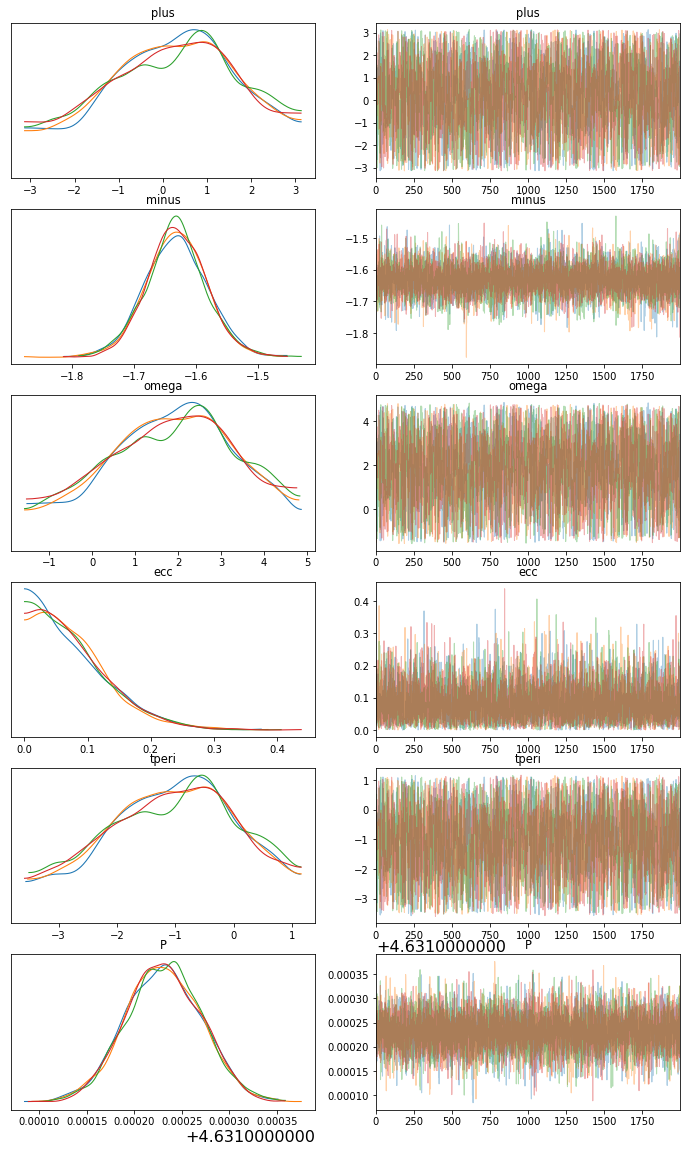

In [16]:
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

_ = az.plot_trace(trace, var_names=['omega', 'ecs', 'ecc', 't0', 'P'], compact=False, figsize=(12,20)) 
#_ = az.plot_trace(trace, var_names=['plus', 'minus', 'omega', 'ecc', 'tperi', 'P'], compact=False, figsize=(12,20))
#plt.savefig('trace_rv_1273_reparam.png',dpi=200,bbox_inches='tight')

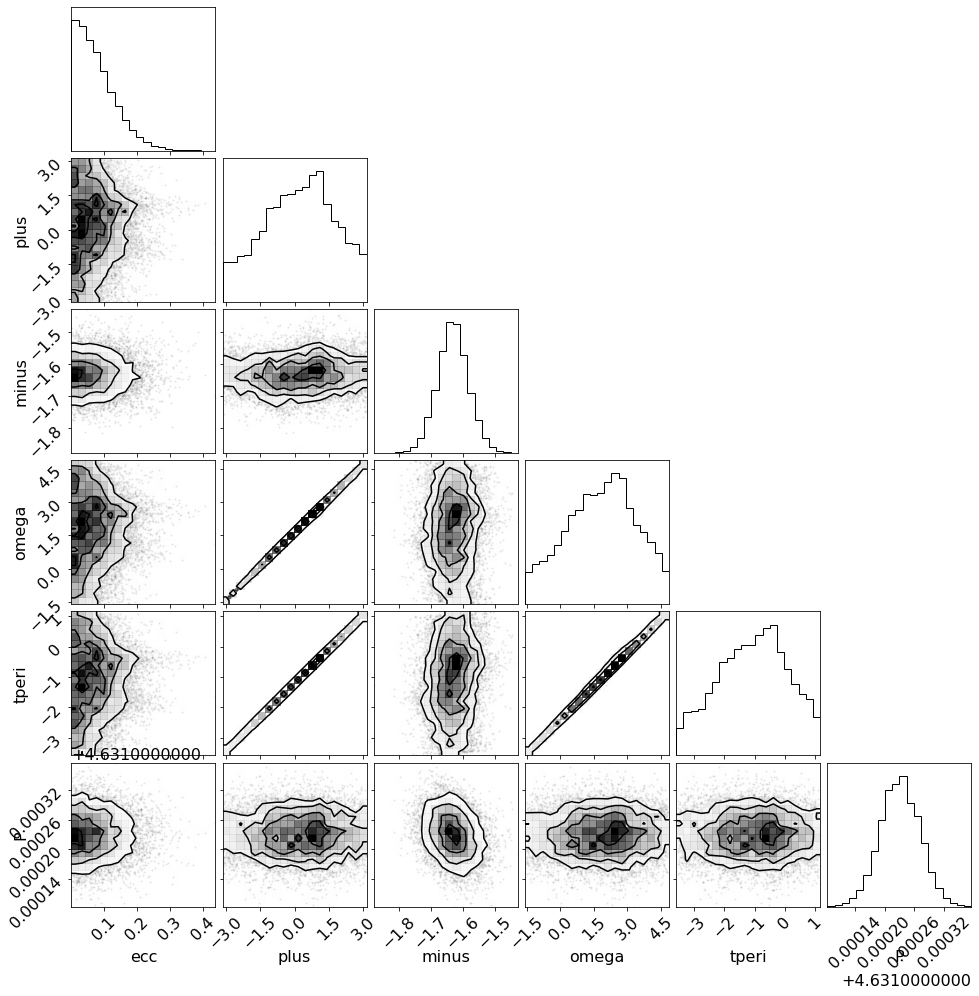

In [17]:
import corner

# parameters = {'P': trace.posterior['P'], 'K': np.exp(trace.posterior['logK']), 
#               'ecc': trace.posterior['ecc'], 'omega': trace.posterior['omega'], 
#               'jitter': np.exp(trace.posterior['logs'])}

with model:
    #_ = corner.corner(parameters)
    _ = corner.corner(trace, var_names=['ecs', 'ecc', 'omega', 't0', 'P']) # free Rvs [trend, logs, ecs, logK, logP, t0]
    #_ = corner.corner(trace, var_names=['ecc', 'plus', 'minus', 'omega', 'tperi', 'P']) # free Rvs [trend, logs, minus, plus, ecc, logK, logP]
#plt.savefig('corner_rv_1273_reparam.png',dpi=200,bbox_inches='tight')

Finally, let's plot the plosterior constraints on the RV model and compare those to the data:

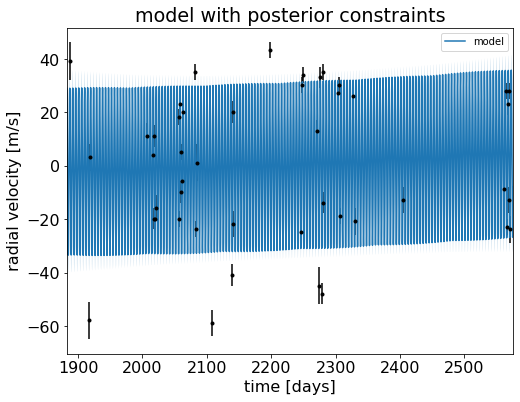

In [18]:
plt.errorbar(x, y, yerr=yerr, fmt=".k")

# Compute the posterior predictions for the RV model
rv_pred = trace.posterior["rv_model_pred"].values
pred = np.percentile(rv_pred, [16, 50, 84], axis=(0, 1))
plt.plot(t, pred[1], color="C0", label="model")
art = plt.fill_between(t, pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(t.min(), t.max())
#plt.xlim(2000,2030)
plt.xlabel("time [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("model with posterior constraints")
#plt.savefig('rvfit_posterior_1273.png',dpi=200,bbox_inches='tight')

## Phase plots

It might be also be interesting to look at the phased plots for this system.
Here we'll fold the dataset on the median of posterior period and then overplot the posterior constraint on the folded model orbits.

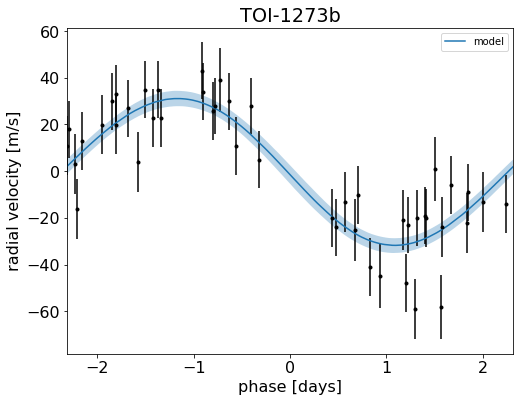

In [19]:
plt.figure()

# Get the posterior median orbital parameters
p = np.median(trace.posterior["P"])
t0 = np.median(trace.posterior["t0"])

# Compute the median of posterior estimate of the background RV
# Then we can remove this from the data to plot just the planet.
other = np.median(trace.posterior["bkg"].values)

# Plot the folded data
x_fold = (x - t0 + 0.5 * p) % p - 0.5 * p
plt.errorbar(x_fold, y - other, yerr=np.sqrt(yerr**2+jitter**2), fmt=".k")

# Compute the posterior prediction for the folded RV model
t_fold = (t - t0 + 0.5 * p) % p - 0.5 * p
inds = np.argsort(t_fold)
pred = np.percentile(trace.posterior["vrad_pred"].values[:, :, inds],[16, 50, 84],axis=(0, 1))
plt.plot(t_fold[inds], pred[1], color="C0", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C0", alpha=0.3)
art.set_edgecolor("none")

plt.legend(fontsize=10)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("phase [days]")
plt.ylabel("radial velocity [m/s]")
_ = plt.title("TOI-1273b")
#plt.savefig('rvfit_1273.png',dpi=200,bbox_inches='tight')